In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint
import tensorflow_addons as tfa
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.applications.vgg19 import VGG19
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Obtener la data 

In [2]:
fpath = 'C:/Users/JOSE/Documents/Septimo/Mineria/Image_processing/Dataset_vid_prueba_train_bg'
random_seed = 9

categories = os.listdir(fpath)
print("Categorias Encontradas = ",categories)

Categorias Encontradas =  ['Blackrot', 'Esca', 'Healthy', 'Leaf_blight']


In [4]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            img_lst.append(np.array(img_array))
            
            labels.append(index)
    return img_lst, labels
images, labels = load_images_and_labels(categories)


In [5]:
images = np.array(images)
labels = np.array(labels)
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1186, 256, 256, 3) 
Labels shape =  (1186,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


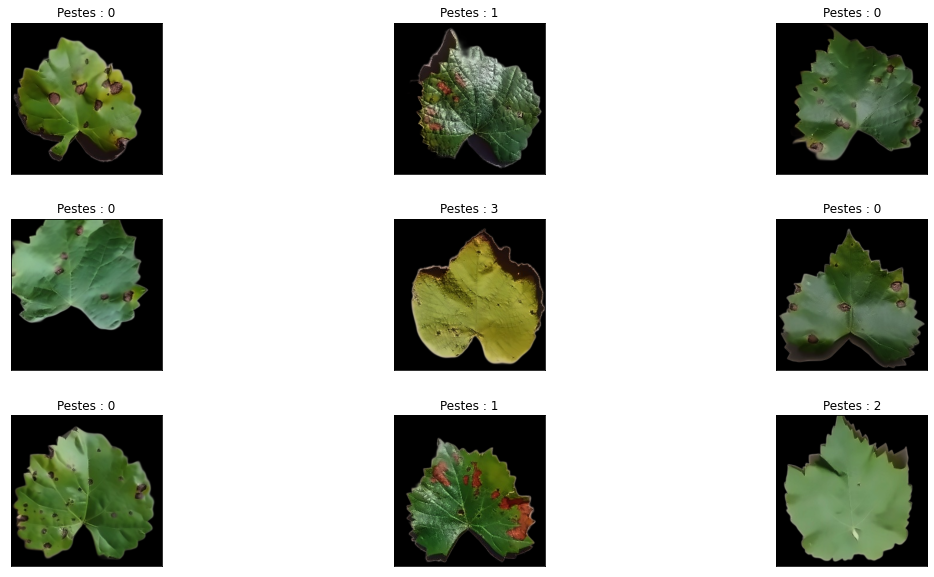

In [6]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Pestes : {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)


# Preparar los datos para el entrenamiento

In [7]:
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1183 1184 1185]

'n' values after shuffling =  [417 517 132 ... 638 348 382]


In [8]:
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)


Images shape after shuffling =  (1186, 256, 256, 3) 
Labels shape after shuffling =  (1186,)


In [9]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1186, 256, 256, 3)


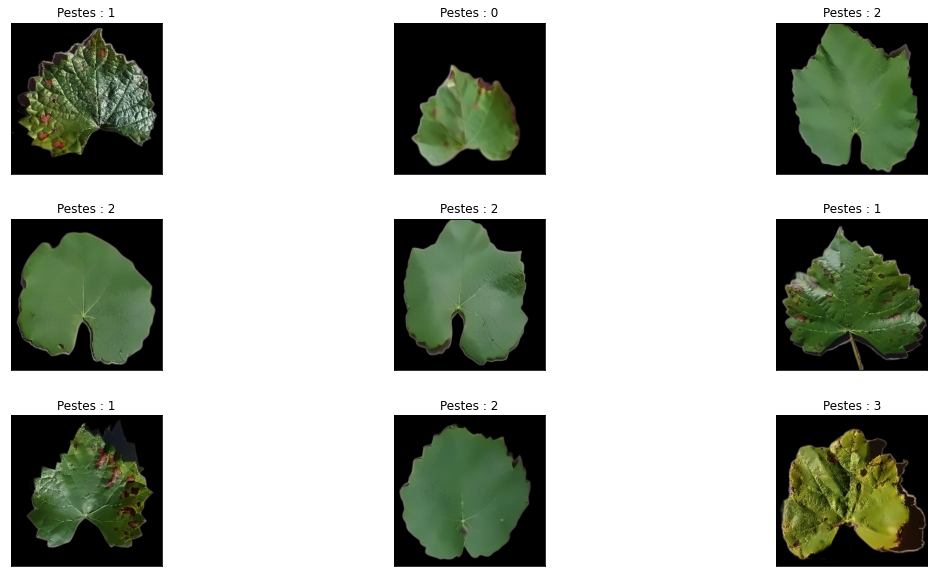

In [10]:
display_rand_images(images, labels)

In [11]:
train_ds, test_ds, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)
print("Tamaño de Caracteristicas Entrenamiento:", train_ds.shape) 
print("Tamaño de Caracteristicas Test:", test_ds.shape)
print("Tamaño de Etiquetas Entrenamiento:", train_labels.shape)
print("Tamaño de Etiquetas Test:", test_labels.shape)

Tamaño de Caracteristicas Entrenamiento: (948, 256, 256, 3)
Tamaño de Caracteristicas Test: (238, 256, 256, 3)
Tamaño de Etiquetas Entrenamiento: (948,)
Tamaño de Etiquetas Test: (238,)


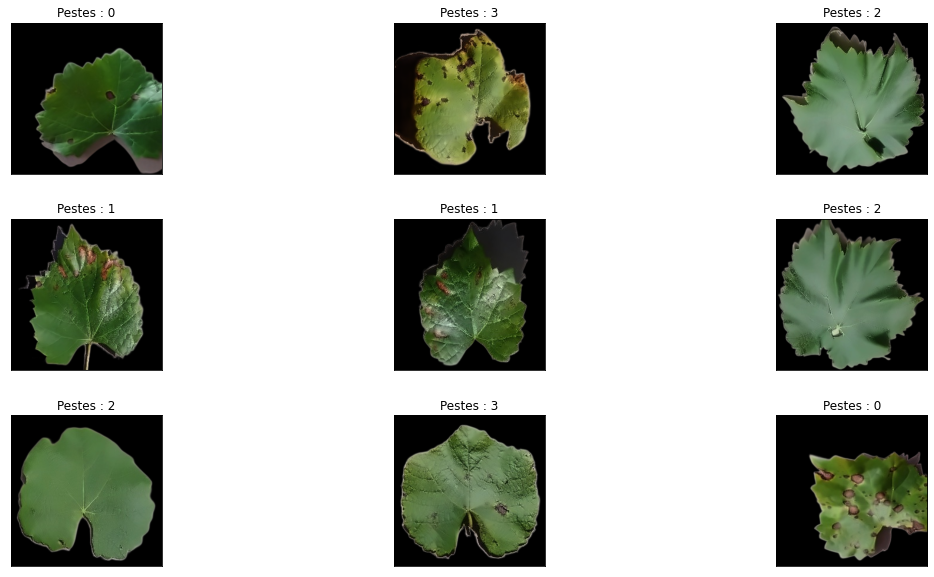

In [12]:
#Ejemplo de variables de entrenamiento
display_rand_images(train_ds, train_labels)

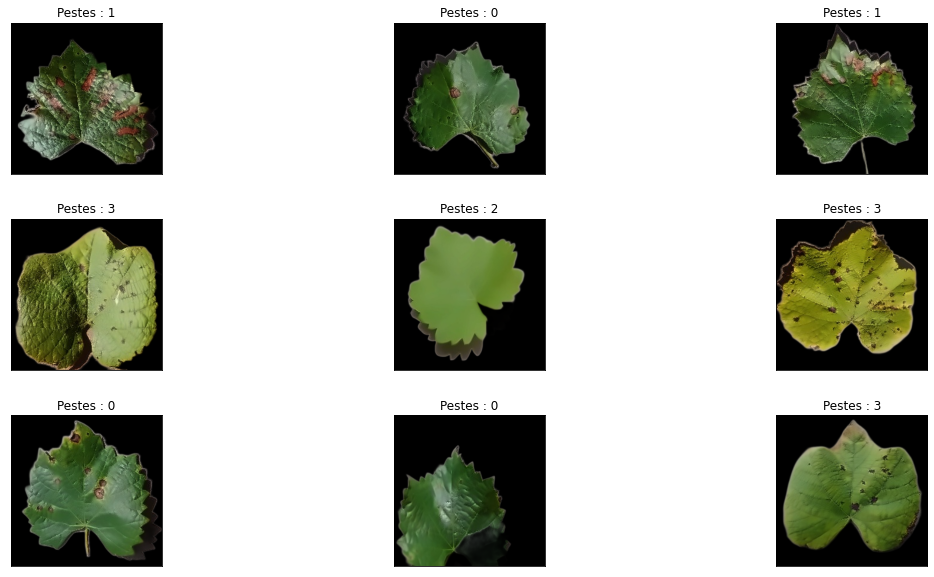

In [13]:
#Ejemplo de variables de test
display_rand_images(test_ds, test_labels)

In [14]:
#Asignar el nuevo valor de tamaño a las imagenes
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))
print("Okey..")

Okey..


# Modelo cnn

In [15]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [22]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(20, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

# Entrenamiento del Modelo Convusional

In [17]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
history = model.fit(train_ds, train_labels, epochs=5, validation_split=0.2, batch_size=32)

Epoch 1/5
24/24 [==============================] - 38s 2s/step - loss: 1.4945 - accuracy: 0.2533 - val_loss: 1.4391 - val_accuracy: 0.2632
Epoch 2/5
24/24 [==============================] - 43s 2s/step - loss: 1.4133 - accuracy: 0.2665 - val_loss: 1.4018 - val_accuracy: 0.2632
Epoch 3/5
24/24 [==============================] - 47s 2s/step - loss: 1.3909 - accuracy: 0.2533 - val_loss: 1.3891 - val_accuracy: 0.2632
Epoch 4/5
24/24 [==============================] - 47s 2s/step - loss: 1.3911 - accuracy: 0.2718 - val_loss: 1.3776 - val_accuracy: 0.2789
Epoch 5/5
24/24 [==============================] - 48s 2s/step - loss: 1.3772 - accuracy: 0.3100 - val_loss: 1.3735 - val_accuracy: 0.2632


In [19]:
_, acc = model.evaluate(test_ds, test_labels, verbose=0)

print('> %.2f' % (acc * 100.0))

> 21.85


In [20]:
model_probs = model.predict(test_ds, verbose=0)
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(test_labels, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(test_labels, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

Accuracy: 21.85
F1 score: 7.84
Precision: 4.77
Recall: 21.85


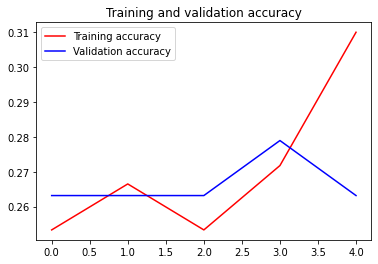

<Figure size 432x288 with 0 Axes>

In [21]:
accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [22]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

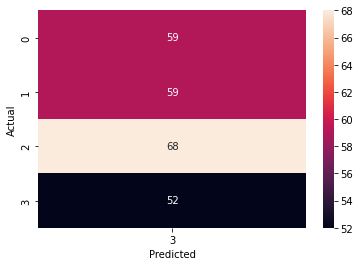

In [23]:
confusion_matrix = pd.crosstab(test_labels, model_classes, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
plt.show()